# **TP2 - Ciencia de Datos**

### **Ejercicio 1 - Análisis Exploratorio**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, accuracy_score

import nltk
import string
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tiefa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### **Lectura del Dataset**

In [2]:
# Lectura del dataset
df = pd.read_csv('tweets_hate_speech.csv')

# Vista de los datos
df.head()

,tweet,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive


#### **Preprocesamiento de Textos**

In [3]:
def clean_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words and len(word) > 3]
    return " ".join(tokens)

df['clean_text'] = df['tweet'].apply(clean_text)

In [4]:
df['clean_text']

0        mayasolovely woman shouldnt complain cleaning ...
1                       mleew17 dats coldtyga cuffin place
2        urkindofbrand dawg 80sbaby4life ever fuck bitc...
3                    cganderson vivabased look like tranny
4        shenikaroberts shit hear might true might fake...
                               ...                        
24778    yous muthafin 8220lifeasking 20pearls coreyema...
24779    youve gone broke wrong heart baby drove rednec...
24780             young buck wanna nigguh like aint fuckin
24781                        youu wild bitches tellin lies
24782    ruffled ntac eileen dahlia beautiful color com...
Name: clean_text, Length: 24783, dtype: object

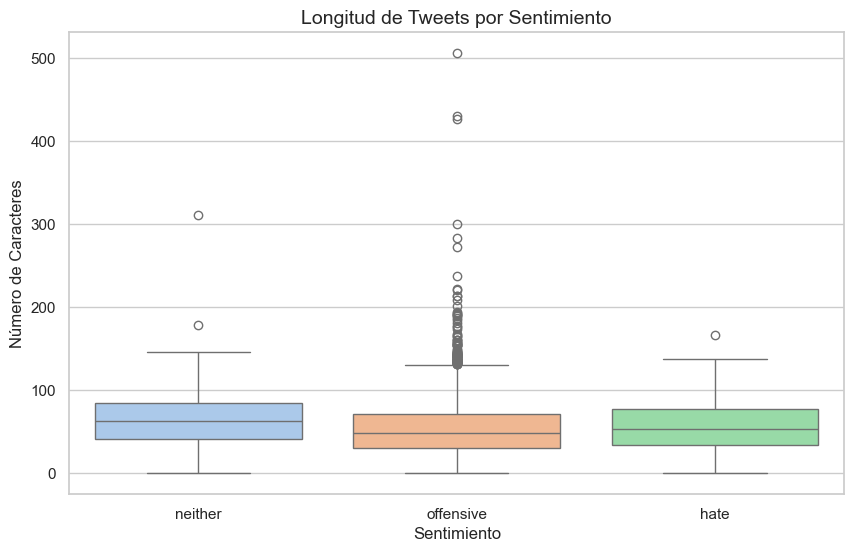

In [5]:
df['length'] = df['clean_text'].apply(len)

# Estilo de Seaborn
sns.set(style="whitegrid")


# Crear el boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='label', y='length', hue='label', palette='pastel', legend=False)

# Títulos y etiquetas
plt.title("Longitud de Tweets por Sentimiento", fontsize=14)
plt.xlabel("Sentimiento", fontsize=12)
plt.ylabel("Número de Caracteres", fontsize=12)

plt.show()

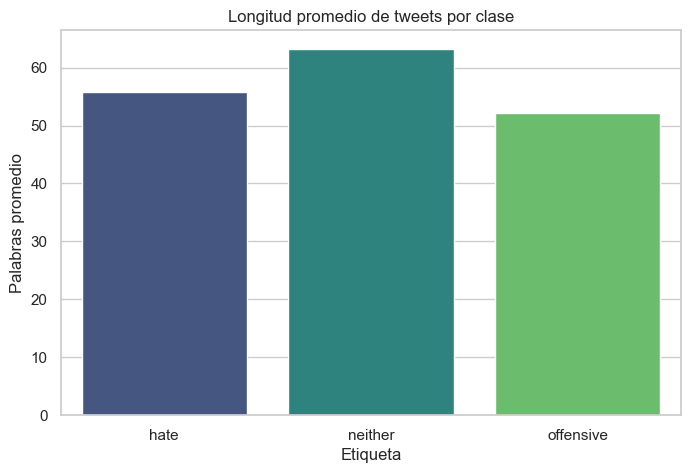

In [6]:
# Longitud promedio de tweets por clase
length_avg = df.groupby('label')['length'].mean().reset_index()

# Visualizar la longitud promedio de tweets por clase
plt.figure(figsize=(8, 5))
sns.barplot(x='label', y='length', hue='label', data=length_avg, palette='viridis', legend=False)
plt.title('Longitud promedio de tweets por clase')
plt.ylabel('Palabras promedio')
plt.xlabel('Etiqueta')
plt.show()

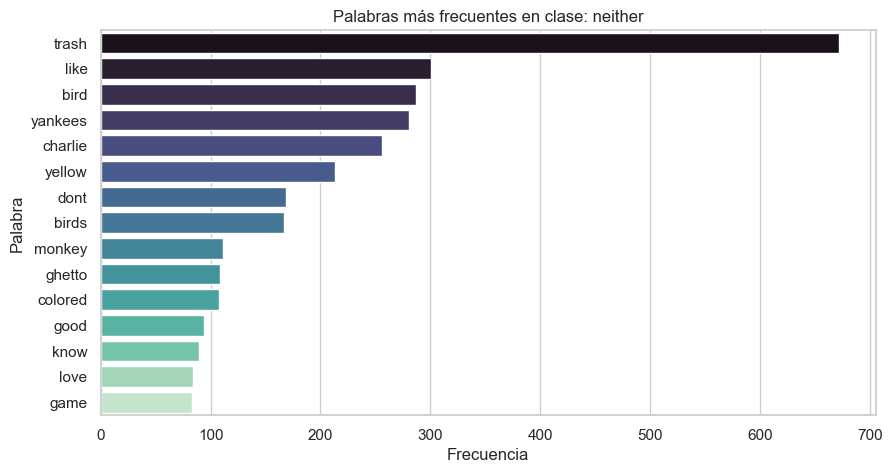

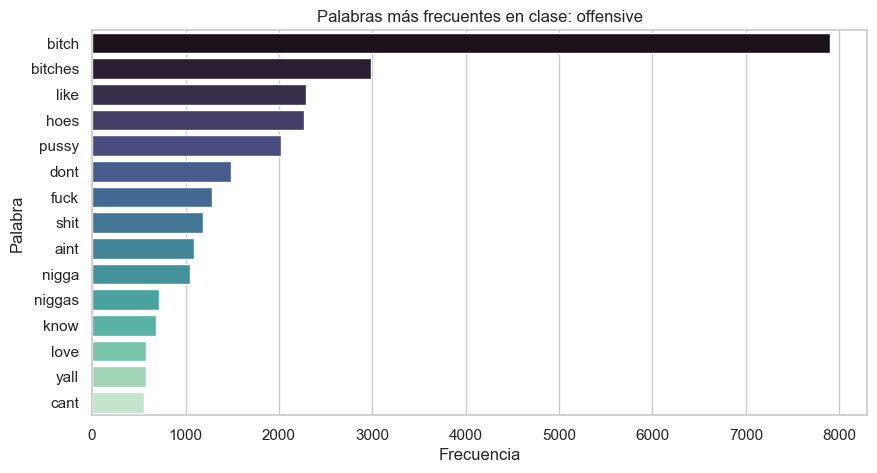

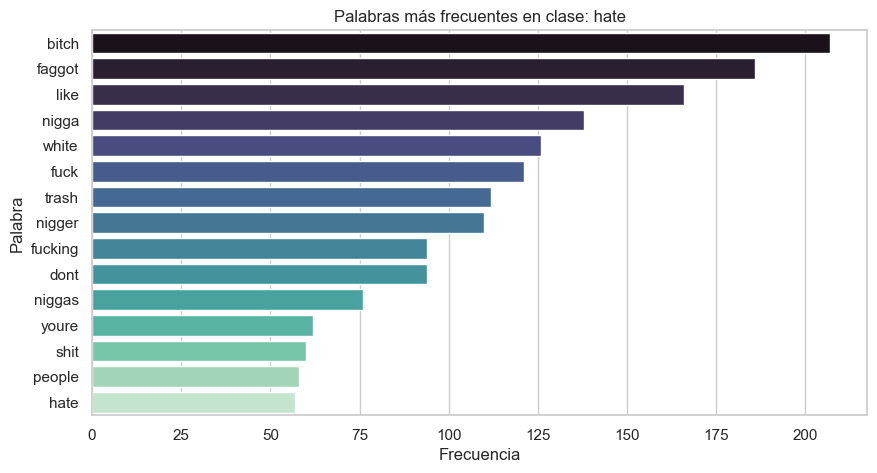

In [7]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_words(label, n=15):
    subset = df[df['label'] == label]
    # Aquí split para obtener listas de palabras desde la columna string clean_text
    all_words = [word for text in subset['clean_text'] for word in text.split()]
    most_common = Counter(all_words).most_common(n)
    words, freqs = zip(*most_common)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(freqs), y=list(words), hue=list(words), palette='mako', legend=False)
    plt.title(f'Palabras más frecuentes en clase: {label}')
    plt.xlabel('Frecuencia')
    plt.ylabel('Palabra')
    plt.show()

# Graficar palabras más comunes por clase
for label in df['label'].unique():
    plot_top_words(label)


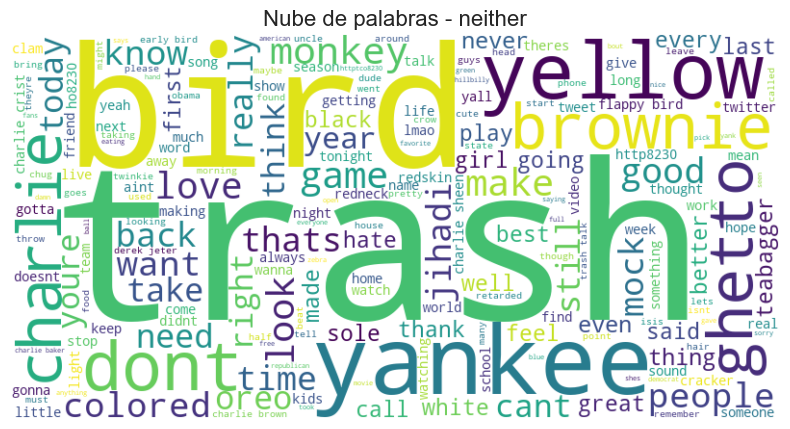

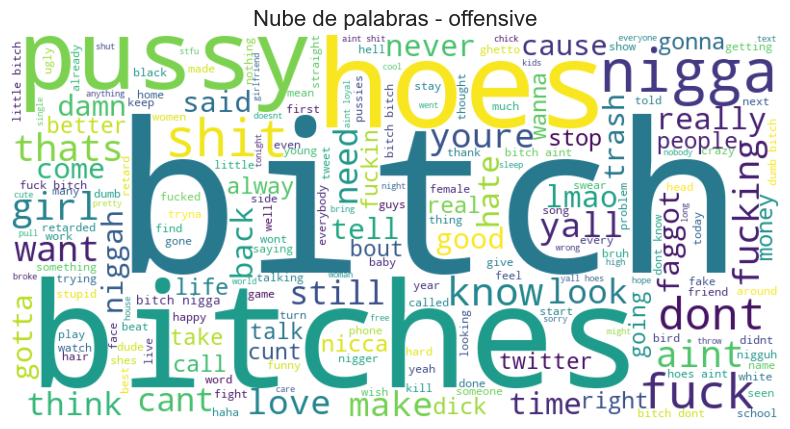

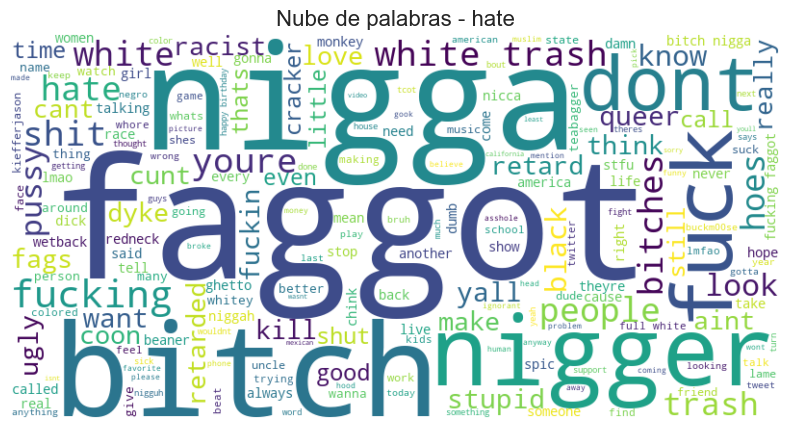

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordcloud(label):
    subset = df[df['label'] == label]
    # Unir todas las palabras de clean_text por cada tweet
    all_words = " ".join(subset['clean_text'])
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Nube de palabras - {label}', fontsize=16)
    plt.axis('off')
    plt.show()

for label in df['label'].unique():
    generate_wordcloud(label)


## **Ejercicio 2 - Procesamiento del conjunto de datos**

In [9]:
# Convertir sentimiento a números
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])  # Guarda el target como número

In [10]:
df['label'].value_counts()

label
2    19190
1     4163
0     1430
Name: count, dtype: int64

In [11]:
y = df['label']

#### **Representación del lenguaje con BoW (Bag of Words)**

In [12]:
bow = CountVectorizer(max_features=5000)
X_bow = bow.fit_transform(df['clean_text'])

In [13]:
X_bow.shape

(24783, 5000)

In [14]:
X_bow

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 132099 stored elements and shape (24783, 5000)>

#### **Representación del lenguaje con TF-IDF**

In [15]:
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['clean_text'])

In [16]:
X_tfidf.shape

(24783, 5000)

In [17]:
X_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 132099 stored elements and shape (24783, 5000)>

#### **Balance del conjunto de datos**

<Axes: xlabel='count', ylabel='label'>

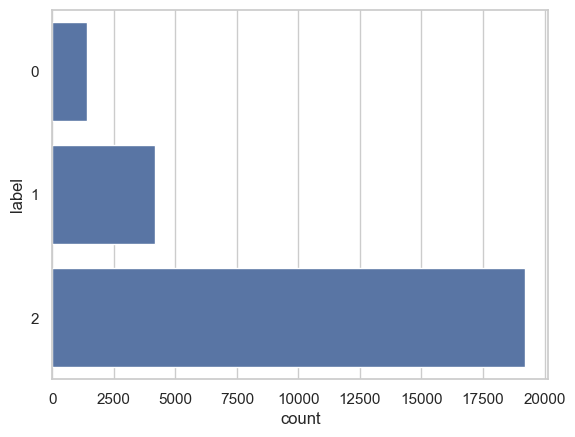

In [18]:
sns.countplot(data=df, y=y)

In [19]:
# SMOTE para balancear ambos conjuntos de datos
smote = SMOTE()

# Para BoW
X_bow_res, y_bow_res = smote.fit_resample(X_bow, y)

# Para TF-IDF
X_tfidf_res, y_tfidf_res = smote.fit_resample(X_tfidf, y)

# Verificamos
print("Distribución balanceada BoW:")
print(pd.Series(y_bow_res).value_counts())

# Verificamos
print("Distribución balanceada TF-IDF:")
print(pd.Series(y_tfidf_res).value_counts())

Distribución balanceada BoW:
label
1    19190
2    19190
0    19190
Name: count, dtype: int64
Distribución balanceada TF-IDF:
label
1    19190
2    19190
0    19190
Name: count, dtype: int64


<Axes: xlabel='count', ylabel='label'>

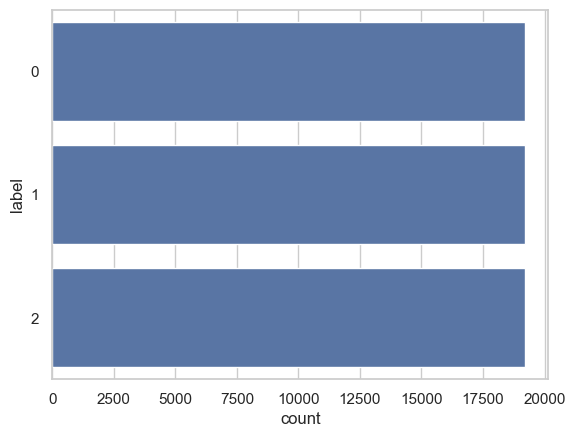

In [20]:
sns.countplot(y=y_bow_res)

In [21]:
# Crear columna 'clean_tokens' a partir de 'clean_text' (que es un string)
df['clean_tokens'] = df['clean_text'].apply(lambda x: x.split())

# Ahora sí puedes comparar ambas columnas
print(df[['clean_tokens', 'clean_text']].head())


                                        clean_tokens  \
0  [mayasolovely, woman, shouldnt, complain, clea...   
1           [mleew17, dats, coldtyga, cuffin, place]   
2  [urkindofbrand, dawg, 80sbaby4life, ever, fuck...   
3        [cganderson, vivabased, look, like, tranny]   
4  [shenikaroberts, shit, hear, might, true, migh...   

                                          clean_text  
0  mayasolovely woman shouldnt complain cleaning ...  
1                 mleew17 dats coldtyga cuffin place  
2  urkindofbrand dawg 80sbaby4life ever fuck bitc...  
3              cganderson vivabased look like tranny  
4  shenikaroberts shit hear might true might fake...  


In [22]:
#Verificar el tipo y forma de la matriz resultante
print(type(X_bow_res)) # Debería ser <class 'scipy.sparse._csr.csr_matrix'>
print("Forma X_bow_res:", X_bow_res.shape) # Cantidad de muestras y features (e.g., (10000, 5000))
print(type(X_tfidf_res)) 
print("Forma X_tfidf_res:", X_tfidf_res.shape)

<class 'scipy.sparse._csr.csr_matrix'>
Forma X_bow_res: (57570, 5000)
<class 'scipy.sparse._csr.csr_matrix'>
Forma X_tfidf_res: (57570, 5000)


In [23]:
# Chequeo de la distribución de clases después del balanceo
print("Distribución de clases después del balanceo (BoW):")
print(y_bow_res.value_counts())
print(y_bow_res.head())
print("Distribución de clases después del balanceo (TF-IDF):")
print(y_tfidf_res.value_counts())
print(y_tfidf_res.head())

Distribución de clases después del balanceo (BoW):
label
1    19190
2    19190
0    19190
Name: count, dtype: int64
0    1
1    2
2    2
3    2
4    2
Name: label, dtype: int64
Distribución de clases después del balanceo (TF-IDF):
label
1    19190
2    19190
0    19190
Name: count, dtype: int64
0    1
1    2
2    2
3    2
4    2
Name: label, dtype: int64


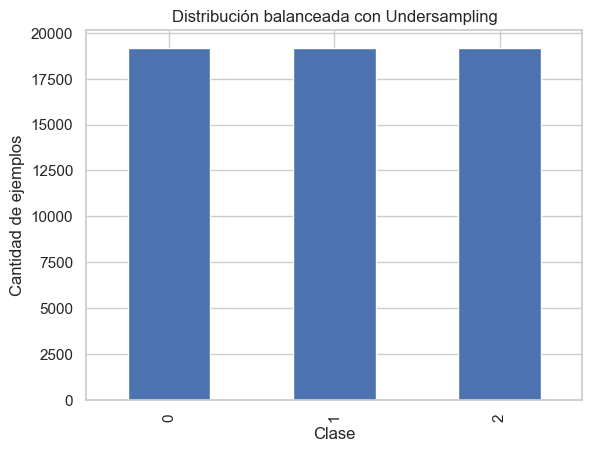

In [24]:
pd.Series(y_bow_res).value_counts().sort_index().plot(kind='bar')

plt.title('Distribución balanceada con Undersampling')
plt.xlabel('Clase')
plt.ylabel('Cantidad de ejemplos')
plt.show()

In [25]:
# Verificacion de formas original y balanceado
print("Tamaño original:", X_tfidf.shape, y.shape)
print("Tamaño tras balanceo:", X_tfidf_res.shape, y_tfidf_res.shape)
print("Tamaño original:", X_bow.shape, y.shape)
print("Tamaño tras balanceo:", X_bow_res.shape, y_bow_res.shape)

Tamaño original: (24783, 5000) (24783,)
Tamaño tras balanceo: (57570, 5000) (57570,)
Tamaño original: (24783, 5000) (24783,)
Tamaño tras balanceo: (57570, 5000) (57570,)


In [26]:
import numpy as np

empty_rows = (X_bow_res.toarray().sum(axis=1) == 0)
print("Filas completamente vacías:", np.sum(empty_rows))

empty_rows = (X_tfidf_res.toarray().sum(axis=1) == 0)
print("Filas completamente vacías:", np.sum(empty_rows))

Filas completamente vacías: 12885
Filas completamente vacías: 597


In [27]:
# Limpiar filas completamente vacías de X_bow_res y y_bow_res
# Identificar índices no vacíos
non_empty_mask = (X_bow_res.toarray().sum(axis=1) != 0)

# Aplicar la máscara para filtrar X e y
X_bow_res = X_bow_res[non_empty_mask]
y_bow_res = y_bow_res[non_empty_mask]

# Limpiar filas completamente vacías de X_tfidf_res y y_tfidf_res
# Identificar índices no vacíos
non_empty_mask = (X_tfidf_res.toarray().sum(axis=1) != 0)

# Aplicar la máscara para filtrar X e y
X_tfidf_res = X_tfidf_res[non_empty_mask]
y_tfidf_res = y_tfidf_res[non_empty_mask]

In [28]:
print("Filas vacías luego de limpieza:", (X_bow_res.toarray().sum(axis=1) == 0).sum())
print("Filas vacías luego de limpieza:", (X_tfidf_res.toarray().sum(axis=1) == 0).sum())

Filas vacías luego de limpieza: 0
Filas vacías luego de limpieza: 0


## **Ejercicio 3 - Modelado**

#### **División dataset en train/test**

In [29]:
# Dividir el dataset en train, validation y test

# === Para BoW ===
# Paso 1: 80% train+val, 20% test
X_bow_temp, X_bow_test, y_bow_temp, y_bow_test = train_test_split(
    X_bow_res, y_bow_res, test_size=0.2, random_state=42, stratify=y_bow_res
)

# Paso 2: 75% train, 25% validación del 80% restante
X_bow_train, X_bow_val, y_bow_train, y_bow_val = train_test_split(
    X_bow_temp, y_bow_temp, test_size=0.25, random_state=42, stratify=y_bow_temp
)

# === Para TF-IDF ===
# Paso 1: 80% train+val, 20% test
X_tfidf_temp, X_tfidf_test, y_tfidf_temp, y_tfidf_test = train_test_split(
    X_tfidf_res, y_tfidf_res, test_size=0.2, random_state=42, stratify=y_tfidf_res
)

# Paso 2: 75% train, 25% validación del 80% restante
X_tfidf_train, X_tfidf_val, y_tfidf_train, y_tfidf_val = train_test_split(
    X_tfidf_temp, y_tfidf_temp, test_size=0.25, random_state=42, stratify=y_tfidf_temp
)

# Verificación de tamaños
print("=== BoW ===")
print(f"Train: {X_bow_train.shape}, Validation: {X_bow_val.shape}, Test: {X_bow_test.shape}")

print("=== TF-IDF ===")
print(f"Train: {X_tfidf_train.shape}, Validation: {X_tfidf_val.shape}, Test: {X_tfidf_test.shape}")


=== BoW ===
Train: (26811, 5000), Validation: (8937, 5000), Test: (8937, 5000)
=== TF-IDF ===
Train: (34183, 5000), Validation: (11395, 5000), Test: (11395, 5000)


#### **Definir modelos de AA**

In [30]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Naive Bayes": MultinomialNB()
}

#### **Entrenar y evaluar modelos**

In [31]:
# Guardar los resultados
resultados_accuracy = []

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_models(X_train, X_test, y_train, y_test, vectorizer_name):
    print(f"\nResultados con {vectorizer_name}:\n" + "-"*40)
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        print(f"\nModelo: {name}")
        print("Accuracy:", acc)
        print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

        # Guardar resultados
        resultados_accuracy.append({
            'Modelo': name,
            'Vectorización': vectorizer_name,
            'Accuracy': acc
        })

        # Mostrar matriz de confusión
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
        disp.plot(cmap="Blues", xticks_rotation=45)
        plt.title(f"Matriz de Confusión - {name} ({vectorizer_name})")
        plt.tight_layout()
        plt.show()


Resultados con Bag of Words:
----------------------------------------

Modelo: Logistic Regression
Accuracy: 0.8662862258028421
              precision    recall  f1-score   support

        hate       0.86      0.78      0.82      2397
     neither       0.87      0.94      0.90      2727
   offensive       0.87      0.87      0.87      3813

    accuracy                           0.87      8937
   macro avg       0.87      0.86      0.86      8937
weighted avg       0.87      0.87      0.87      8937



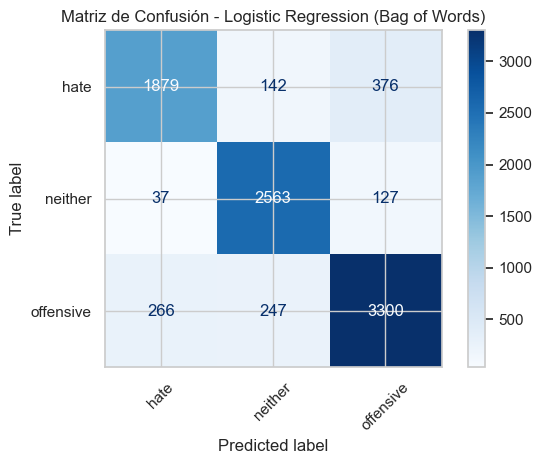


Modelo: Random Forest
Accuracy: 0.8446906120622133
              precision    recall  f1-score   support

        hate       0.74      0.89      0.81      2397
     neither       0.86      0.94      0.90      2727
   offensive       0.93      0.75      0.83      3813

    accuracy                           0.84      8937
   macro avg       0.84      0.86      0.85      8937
weighted avg       0.86      0.84      0.84      8937



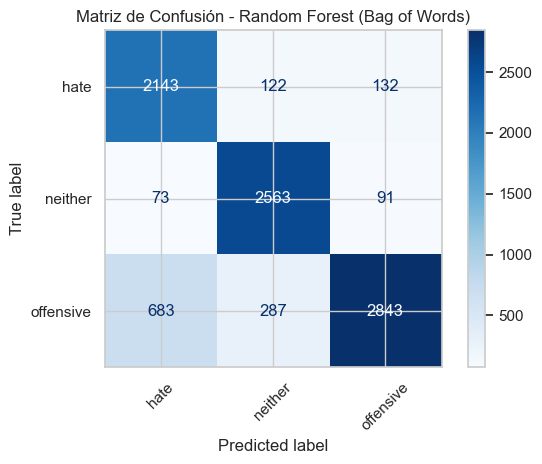


Modelo: Naive Bayes
Accuracy: 0.8444668233187871
              precision    recall  f1-score   support

        hate       0.84      0.73      0.79      2397
     neither       0.91      0.88      0.89      2727
   offensive       0.80      0.89      0.84      3813

    accuracy                           0.84      8937
   macro avg       0.85      0.83      0.84      8937
weighted avg       0.85      0.84      0.84      8937



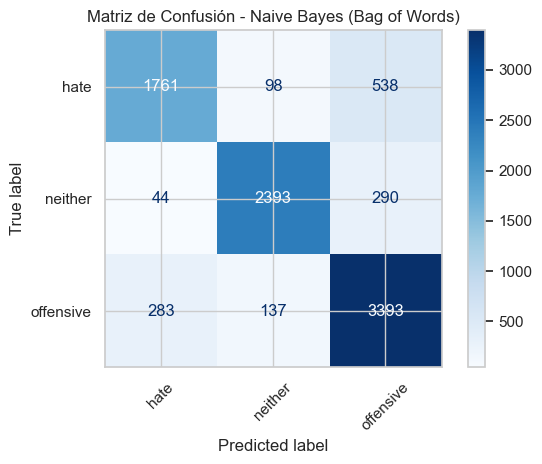

In [32]:
# Evaluación con BoW
evaluate_models(X_bow_train, X_bow_test, y_bow_train, y_bow_test, "Bag of Words")


Resultados con TF-IDF:
----------------------------------------

Modelo: Logistic Regression
Accuracy: 0.8880210618692409
              precision    recall  f1-score   support

        hate       0.87      0.88      0.88      3782
     neither       0.88      0.96      0.92      3800
   offensive       0.92      0.82      0.86      3813

    accuracy                           0.89     11395
   macro avg       0.89      0.89      0.89     11395
weighted avg       0.89      0.89      0.89     11395



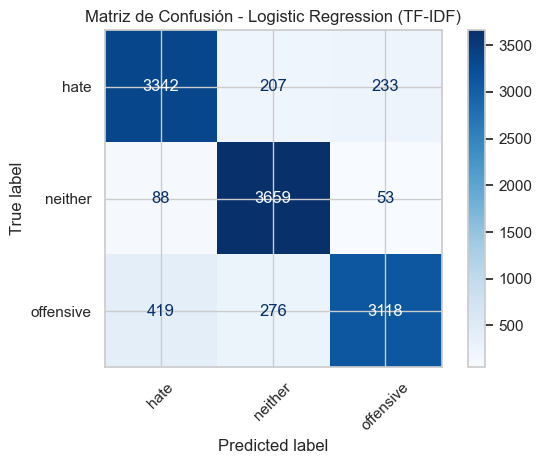


Modelo: Random Forest
Accuracy: 0.9383940324703818
              precision    recall  f1-score   support

        hate       0.93      0.97      0.95      3782
     neither       0.92      0.98      0.95      3800
   offensive       0.97      0.87      0.92      3813

    accuracy                           0.94     11395
   macro avg       0.94      0.94      0.94     11395
weighted avg       0.94      0.94      0.94     11395



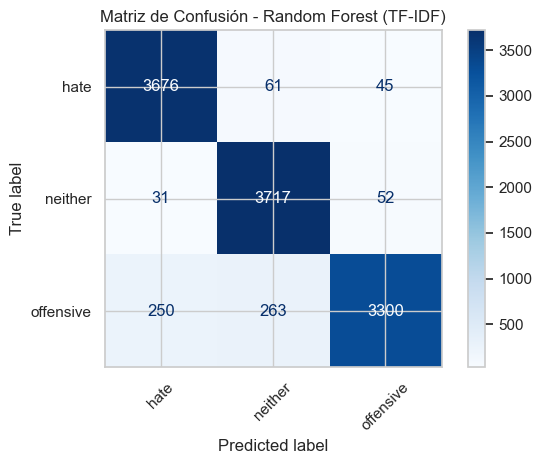


Modelo: Naive Bayes
Accuracy: 0.8329969284774024
              precision    recall  f1-score   support

        hate       0.82      0.81      0.81      3782
     neither       0.91      0.88      0.89      3800
   offensive       0.78      0.81      0.80      3813

    accuracy                           0.83     11395
   macro avg       0.83      0.83      0.83     11395
weighted avg       0.83      0.83      0.83     11395



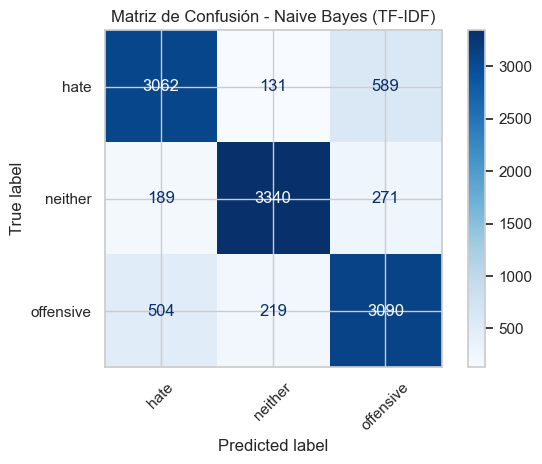

In [33]:
# Evaluación con TF-IDF
evaluate_models(X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test, "TF-IDF")

#### **Resultados**

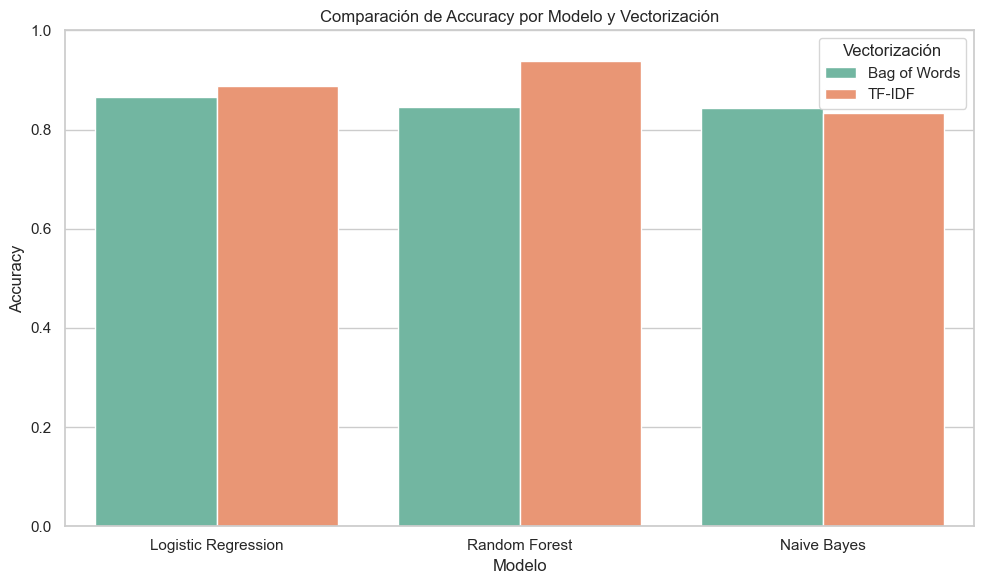

In [34]:
df_results = pd.DataFrame(resultados_accuracy)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_results, x='Modelo', y='Accuracy', hue='Vectorización', palette='Set2')
plt.title('Comparación de Accuracy por Modelo y Vectorización')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()